# 72-Hour Renewable Energy Forecast (CycleLSTM) - TensorFlow Version

**Project Overview:**
This notebook implements a 72-hour renewable energy forecast using a **CycleLSTM** model, converted to **TensorFlow/Keras**. The model architecture is designed to capture and utilize cyclical (e.g., daily) patterns in time series data.

**Key TensorFlow/Keras Components:**
1.  **Data Pipeline:** Uses `tf.data.Dataset` for efficient batching and processing.
2.  **Custom Layer:** A custom `RecurrentCycle` Keras layer is created to manage the trainable cyclical memory.
3.  **Model:** The `CycleLSTMModel` is built by subclassing `tf.keras.Model` to integrate the custom cycle logic directly into the forward pass.
4.  **Training:** Standard Keras `.fit()` is used with callbacks like `ReduceLROnPlateau` and `EarlyStopping` for robust training.

In [1]:
# Cell 1: Necessary Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import os

C:\Users\anikk\anaconda3\envs\codegreen\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Cell 2: Configuration

config = {
    'data_params': {
        'country_code': 'DE',
        'years_history': 5,
        'target_variable': 'renewable_percentage'
    },
    'model_params': {
        'input_length': 72,       # Use past 72 hours (3 days) of data
        'output_length': 72,      # Predict next 72 hours
        'lstm_input_size': 1,     # Number of features
        'hidden_size': 64,
        'num_layers': 2,
        'dropout': 0.2,
        'cycle_len': 24,            # Daily seasonality for hourly data
        'cycle_channel_size': 1
    },
    'training_params': {
        'batch_size': 32,
        'num_epochs': 500,
        'initial_learning_rate': 0.001,
        'patience_lr': 2,
        'lr_reduction': 0.1,
        'min_learning_rate': 1e-05,
        'early_stopping_patience': 3
    }
}

DATA_FILENAME = f"energy_data_{config['data_params']['country_code']}_{config['data_params']['years_history']}years.csv"

### Data Loading and Preprocessing

In [3]:
# Cell 3: Data Handling and Splitting Functions

def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    """Splits the dataset into train, validation, and test sets."""
    total_len = len(data)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    return train_data, val_data, test_data

def fit_scaler(train_data):
    """Fits a MinMaxScaler using the training data."""
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    return scaler

def create_sequences_with_cycle(data, input_length, output_length, cycle_len):
    """Creates input/output sequences and corresponding cycle indices."""
    x_list, y_list, cycle_idx_list = [], [], []
    cycle_indices = (np.arange(len(data)) % cycle_len).reshape(-1, 1)
    for i in range(len(data) - input_length - output_length + 1):
        x_list.append(data[i : i + input_length])
        y_list.append(data[i + input_length : i + input_length + output_length])
        cycle_idx_list.append(cycle_indices[i])
    return np.array(x_list), np.array(y_list), np.array(cycle_idx_list, dtype=np.int32)

In [4]:
# Cell 4: Load and Prepare Data for TensorFlow

print(f"Loading data from file: {DATA_FILENAME}")
try:
    cached_data = pd.read_csv(DATA_FILENAME, index_col=0, parse_dates=True)
    renewable_series = cached_data[[config['data_params']['target_variable']]]
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"CRITICAL: Data file not found at '{os.path.abspath(DATA_FILENAME)}'.")
    renewable_series = None

if renewable_series is not None:
    train_data, val_data, test_data = train_val_test_split(renewable_series.values)
    scaler = fit_scaler(train_data)
    
    # Scale data
    train_scaled = scaler.transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)

    # Create sequences
    X_train, y_train, cycle_train = create_sequences_with_cycle(train_scaled, config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])
    X_val, y_val, cycle_val = create_sequences_with_cycle(val_scaled, config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])
    X_test, y_test, cycle_test = create_sequences_with_cycle(test_scaled, config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])

    # Create tf.data.Dataset objects
    train_ds = tf.data.Dataset.from_tensor_slices(((X_train, cycle_train), y_train)).batch(config['training_params']['batch_size']).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices(((X_val, cycle_val), y_val)).batch(config['training_params']['batch_size']).prefetch(tf.data.AUTOTUNE)
    test_ds = tf.data.Dataset.from_tensor_slices(((X_test, cycle_test), y_test)).batch(config['training_params']['batch_size']).prefetch(tf.data.AUTOTUNE)

    print("TensorFlow Datasets created.")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, cycle_train_shape: {cycle_train.shape}")

Loading data from file: energy_data_DE_5years.csv
Data loaded successfully.
TensorFlow Datasets created.
X_train shape: (30516, 72, 1), y_train shape: (30516, 72, 1), cycle_train_shape: (30516, 1)


### CycleLSTM Model Definition (TensorFlow)

In [5]:
# Cell 5: RecurrentCycle Custom Keras Layer

class RecurrentCycle(layers.Layer):
    def __init__(self, cycle_len, channel_size, **kwargs):
        super(RecurrentCycle, self).__init__(**kwargs)
        self.cycle_len = cycle_len
        self.channel_size = channel_size

    def build(self, input_shape):
        self.data = self.add_weight(
            shape=(self.cycle_len, self.channel_size),
            initializer="zeros",
            trainable=True,
            name="cycle_memory"
        )
        super().build(input_shape)

    def call(self, index, length=None):
        if length is None:
            raise ValueError("The 'length' argument must be provided.")
        
        idx_flat = tf.reshape(index, [-1, 1])
        range_tensor = tf.range(length, dtype=tf.int32)
        range_tensor = tf.reshape(range_tensor, [1, -1])
        gather_index = (idx_flat + range_tensor) % self.cycle_len
        return tf.gather(self.data, gather_index)

In [6]:
# Cell 6: CycleLSTM Keras Model

class CycleLSTMModel(keras.Model):
    def __init__(self, hidden_size, num_layers, output_size, cycle_len, cycle_channel_size, seq_len, dropout=0.2, **kwargs):
        super(CycleLSTMModel, self).__init__(**kwargs)
        self.output_size = output_size
        self.seq_len = seq_len
        self.cycle_len = cycle_len
        
        self.cycle_queue = RecurrentCycle(cycle_len=cycle_len, channel_size=cycle_channel_size)
        
        self.lstm_layers = []
        for i in range(num_layers - 1):
            self.lstm_layers.append(layers.LSTM(hidden_size, return_sequences=True, dropout=dropout))
        self.lstm_layers.append(layers.LSTM(hidden_size, return_sequences=False, dropout=dropout))

        self.fc = layers.Dense(output_size)

    def call(self, inputs):
        x, index = inputs
        
        cq = self.cycle_queue(index, length=self.seq_len)
        x = x - cq
        
        out = x
        for lstm_layer in self.lstm_layers:
            out = lstm_layer(out)
        
        out = self.fc(out)
        
        future_index = (index + self.seq_len) % self.cycle_len
        cp = self.cycle_queue(future_index, length=self.output_size)
        
        out = out + tf.squeeze(cp, axis=-1)
        
        out = tf.expand_dims(out, axis=-1)
        return out

### Training and Initial Evaluation

In [7]:
# Cell 7: Plotting Utility Functions

def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.show()

--- Starting CycleLSTM Model Training (TensorFlow) ---

Epoch 1/10
1908/1908 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - loss: 0.0416 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 2/10
1908/1908 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 0.0246 - val_loss: 0.0492 - learning_rate: 0.0010
Epoch 3/10
1908/1908 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 0.0244 - val_loss: 0.0517 - learning_rate: 0.0010
Epoch 4/10
1908/1908 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - loss: 0.0240 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 5/10
1908/1908 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 0.0233 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 6/10
1908/1908 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 0.0233 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 7/10
1908/1908 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.0233 - val_loss: 0.0469 - learning_rate: 0.0010
Epoch 8/10
1908/1908 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - loss: 0.0242 - val_loss: 0.0408 - learning_rate: 1.0000e-04
Epoch 9/10
1908/1908 ━━━━━━━

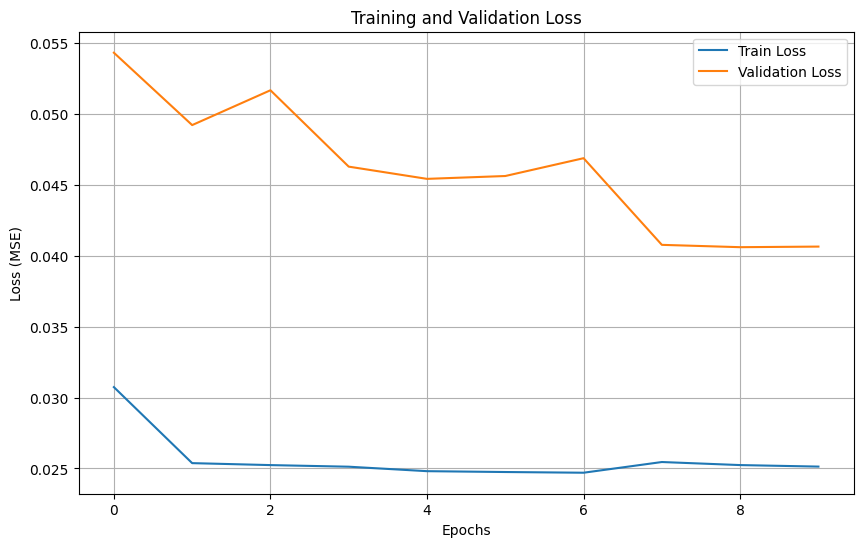

In [8]:
# Cell 8: Run Training

if 'train_ds' in locals():
    # Initialize the model
    model = CycleLSTMModel(
        hidden_size=config['model_params']['hidden_size'],
        num_layers=config['model_params']['num_layers'],
        output_size=config['model_params']['output_length'],
        cycle_len=config['model_params']['cycle_len'],
        cycle_channel_size=config['model_params']['cycle_channel_size'],
        seq_len=config['model_params']['input_length'],
        dropout=config['model_params']['dropout']
    )
    
    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=config['training_params']['initial_learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')
    
    # Define callbacks
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=config['training_params']['lr_reduction'], 
        patience=config['training_params']['patience_lr'], 
        min_lr=config['training_params']['min_learning_rate']
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=config['training_params']['early_stopping_patience'], 
        restore_best_weights=True
    )

    print("--- Starting CycleLSTM Model Training (TensorFlow) ---\n")
    history = model.fit(
        train_ds,
        epochs=config['training_params']['num_epochs'],
        validation_data=val_ds,
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )
    
    plot_training_history(history)
else:
    print("Data not loaded. Cannot run training and evaluation.")

### Final Model Evaluation and Visualization


--- Final Model Evaluation on Test Set ---
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

Overall Test Set Metrics (on inverse-transformed data):
  Mean Absolute Error (MAE): 12.3014
  Mean Squared Error (MSE):  226.6343
  Root Mean Squared Error (RMSE): 15.0544


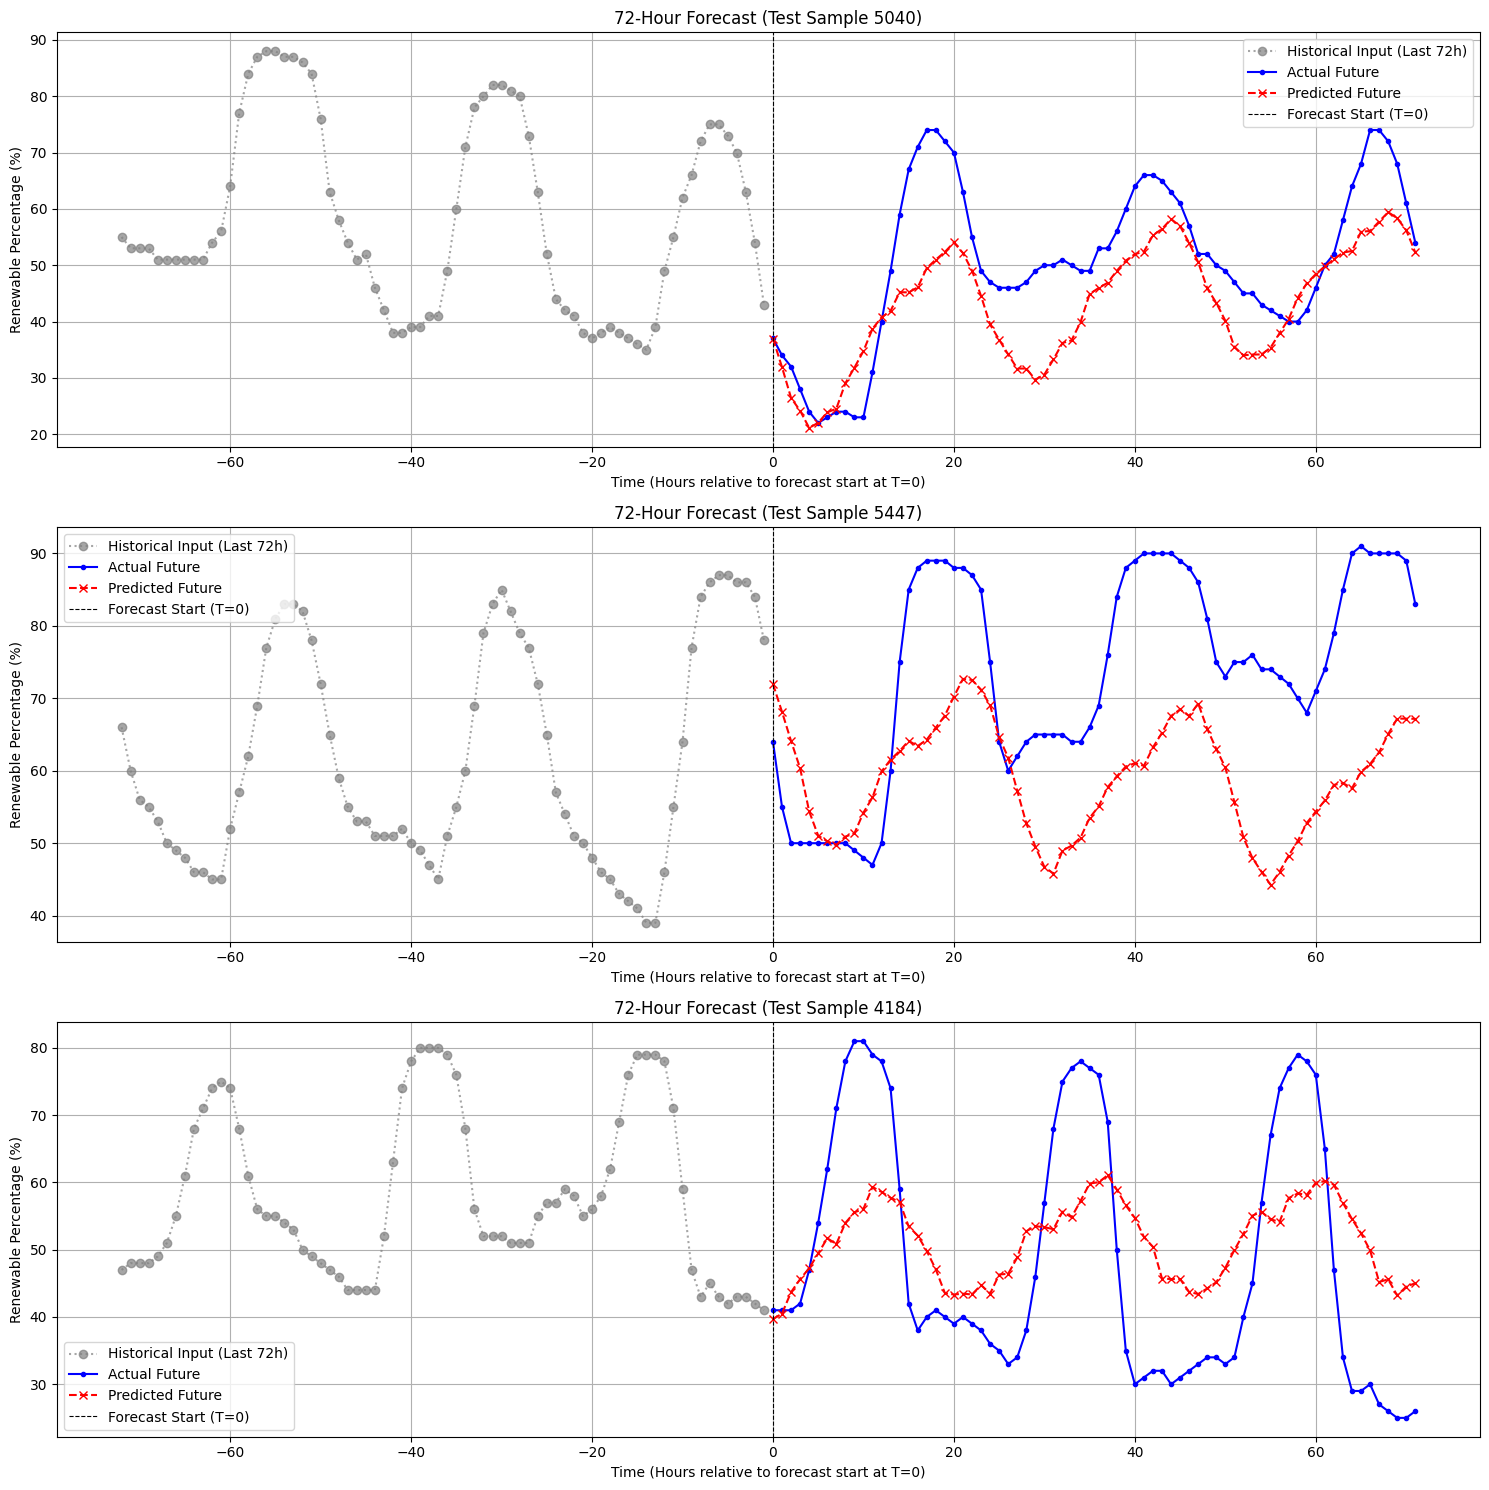

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# # 72-Hour Renewable Energy Forecast (CycleLSTM) - TensorFlow Version

# **Project Overview:**
# This notebook implements a 72-hour renewable energy forecast using a **CycleLSTM** model, converted to **TensorFlow/Keras**. The model architecture is designed to capture and utilize cyclical (e.g., daily) patterns in time series data.
#
# **Key TensorFlow/Keras Components:**
# 1.  **Data Pipeline:** Uses `tf.data.Dataset` for efficient batching and processing.
# 2.  **Custom Layer:** A custom `RecurrentCycle` Keras layer is created to manage the trainable cyclical memory.
# 3.  **Model:** The `CycleLSTMModel` is built by subclassing `tf.keras.Model` to integrate the custom cycle logic directly into the forward pass.
# 4.  **Training:** Standard Keras `.fit()` is used with callbacks like `ReduceLROnPlateau`.

# %%
# Cell 1: Necessary Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import os

# %%
# Cell 2: Configuration

config = {
    'data_params': {
        'country_code': 'DE',
        'years_history': 5,
        'target_variable': 'renewable_percentage'
    },
    'model_params': {
        'input_length': 72,       # Use past 72 hours (3 days) of data
        'output_length': 72,      # Predict next 72 hours
        'lstm_input_size': 1,     # Number of features
        'hidden_size': 64,
        'num_layers': 2,
        'dropout': 0.2,
        'cycle_len': 24,            # Daily seasonality for hourly data
        'cycle_channel_size': 1
    },
    'training_params': {
        'batch_size': 32,
        'num_epochs': 500,
        'initial_learning_rate': 0.001,
        'patience_lr': 2,
        'lr_reduction': 0.1,
        'min_learning_rate': 1e-05
    }
}

DATA_FILENAME = f"energy_data_{config['data_params']['country_code']}_{config['data_params']['years_history']}years.csv"

# ### Data Loading and Preprocessing

# %%
# Cell 3: Data Handling and Splitting Functions

def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    """Splits the dataset into train, validation, and test sets."""
    total_len = len(data)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    return train_data, val_data, test_data

def fit_scaler(train_data):
    """Fits a MinMaxScaler using the training data."""
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    return scaler

def create_sequences_with_cycle(data, input_length, output_length, cycle_len):
    """Creates input/output sequences and corresponding cycle indices."""
    x_list, y_list, cycle_idx_list = [], [], []
    cycle_indices = (np.arange(len(data)) % cycle_len).reshape(-1, 1)
    for i in range(len(data) - input_length - output_length + 1):
        x_list.append(data[i : i + input_length])
        y_list.append(data[i + input_length : i + input_length + output_length])
        cycle_idx_list.append(cycle_indices[i])
    return np.array(x_list), np.array(y_list), np.array(cycle_idx_list, dtype=np.int32)

# %%
# Cell 4: Load and Prepare Data for TensorFlow

print(f"Loading data from file: {DATA_FILENAME}")
try:
    cached_data = pd.read_csv(DATA_FILENAME, index_col=0, parse_dates=True)
    renewable_series = cached_data[[config['data_params']['target_variable']]]
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"CRITICAL: Data file not found at '{os.path.abspath(DATA_FILENAME)}'.")
    renewable_series = None

if renewable_series is not None:
    train_data, val_data, test_data = train_val_test_split(renewable_series.values)
    scaler = fit_scaler(train_data)

    # Scale data
    train_scaled = scaler.transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)

    # Create sequences
    X_train, y_train, cycle_train = create_sequences_with_cycle(train_scaled, config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])
    X_val, y_val, cycle_val = create_sequences_with_cycle(val_scaled, config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])
    X_test, y_test, cycle_test = create_sequences_with_cycle(test_scaled, config['model_params']['input_length'], config['model_params']['output_length'], config['model_params']['cycle_len'])

    # Create tf.data.Dataset objects
    train_ds = tf.data.Dataset.from_tensor_slices(((X_train, cycle_train), y_train)).batch(config['training_params']['batch_size']).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices(((X_val, cycle_val), y_val)).batch(config['training_params']['batch_size']).prefetch(tf.data.AUTOTUNE)
    test_ds = tf.data.Dataset.from_tensor_slices(((X_test, cycle_test), y_test)).batch(config['training_params']['batch_size']).prefetch(tf.data.AUTOTUNE)

    print("TensorFlow Datasets created.")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, cycle_train_shape: {cycle_train.shape}")

# ### CycleLSTM Model Definition (TensorFlow)

# %%
# Cell 5: RecurrentCycle Custom Keras Layer

class RecurrentCycle(layers.Layer):
    def __init__(self, cycle_len, channel_size, **kwargs):
        super(RecurrentCycle, self).__init__(**kwargs)
        self.cycle_len = cycle_len
        self.channel_size = channel_size

    def build(self, input_shape):
        self.data = self.add_weight(
            shape=(self.cycle_len, self.channel_size),
            initializer="zeros",
            trainable=True,
            name="cycle_memory"
        )
        super().build(input_shape)

    def call(self, index, length=None):
        if length is None:
            raise ValueError("The 'length' argument must be provided.")

        idx_flat = tf.reshape(index, [-1, 1])
        range_tensor = tf.range(length, dtype=tf.int32)
        range_tensor = tf.reshape(range_tensor, [1, -1])
        gather_index = (idx_flat + range_tensor) % self.cycle_len
        return tf.gather(self.data, gather_index)

# %%
# Cell 6: CycleLSTM Keras Model

class CycleLSTMModel(keras.Model):
    def __init__(self, hidden_size, num_layers, output_size, cycle_len, cycle_channel_size, seq_len, dropout=0.2, **kwargs):
        super(CycleLSTMModel, self).__init__(**kwargs)
        self.output_size = output_size
        self.seq_len = seq_len
        self.cycle_len = cycle_len

        self.cycle_queue = RecurrentCycle(cycle_len=cycle_len, channel_size=cycle_channel_size)

        self.lstm_layers = []
        for i in range(num_layers - 1):
            self.lstm_layers.append(layers.LSTM(hidden_size, return_sequences=True, dropout=dropout))
        self.lstm_layers.append(layers.LSTM(hidden_size, return_sequences=False, dropout=dropout))

        self.fc = layers.Dense(output_size)

    def call(self, inputs):
        x, index = inputs

        cq = self.cycle_queue(index, length=self.seq_len)
        x = x - cq

        out = x
        for lstm_layer in self.lstm_layers:
            out = lstm_layer(out)

        out = self.fc(out)

        future_index = (index + self.seq_len) % self.cycle_len
        cp = self.cycle_queue(future_index, length=self.output_size)

        out = out + tf.squeeze(cp, axis=-1)

        out = tf.expand_dims(out, axis=-1)
        return out

# ### Training and Initial Evaluation

# %%
# Cell 7: Plotting Utility Functions

def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.savefig("training_validation_loss.png") # Save the plot
    # plt.show()

# %%
# Cell 8: Run Training

if 'train_ds' in locals():
    # Initialize the model
    model = CycleLSTMModel(
        hidden_size=config['model_params']['hidden_size'],
        num_layers=config['model_params']['num_layers'],
        output_size=config['model_params']['output_length'],
        cycle_len=config['model_params']['cycle_len'],
        cycle_channel_size=config['model_params']['cycle_channel_size'],
        seq_len=config['model_params']['input_length'],
        dropout=config['model_params']['dropout']
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=config['training_params']['initial_learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')

    # Define callbacks
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=config['training_params']['lr_reduction'],
        patience=config['training_params']['patience_lr'],
        min_lr=config['training_params']['min_learning_rate']
    )

    print("---\nStarting CycleLSTM Model Training (TensorFlow) ---\n")
    history = model.fit(
        train_ds,
        epochs=config['training_params']['num_epochs'],
        validation_data=val_ds,
        callbacks=[reduce_lr], # Early stopping removed from this list
        verbose=1
    )

    plot_training_history(history)
else:
    print("Data not loaded. Cannot run training and evaluation.")

# ### Final Model Evaluation and Visualization

# %%
# Cell 9: Final Model Evaluation on Test Set

if 'model' in locals() and 'test_ds' in locals() and X_test.shape[0] > 0 and y_test.shape[0] > 0:
    print("\n--- Final Model Evaluation on Test Set ---")
    # Make predictions on the entire test set
    y_pred_scaled = model.predict(test_ds)

    # Flatten the arrays to treat each predicted point independently for metric calculation
    y_test_flat_scaled = y_test.flatten().reshape(-1, 1)
    y_pred_flat_scaled = y_pred_scaled.flatten().reshape(-1, 1)

    y_test_inversed_flat = scaler.inverse_transform(y_test_flat_scaled).flatten()
    y_pred_inversed_flat = scaler.inverse_transform(y_pred_flat_scaled).flatten()

    # Calculate metrics
    mae_overall = mean_absolute_error(y_test_inversed_flat, y_pred_inversed_flat)
    mse_overall = mean_squared_error(y_test_inversed_flat, y_pred_inversed_flat)
    rmse_overall = np.sqrt(mse_overall)

    print(f"\nOverall Test Set Metrics (on inverse-transformed data):")
    print(f"  Mean Absolute Error (MAE): {mae_overall:.4f}")
    print(f"  Mean Squared Error (MSE):  {mse_overall:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse_overall:.4f}")

    # Plot a few examples of predictions vs actuals from the test set
    LOOK_BACK = config['model_params']['input_length']
    FORECAST_HORIZON = config['model_params']['output_length']
    num_plots = min(3, len(X_test))
    if num_plots > 0:
        plt.figure(figsize=(15, 5 * num_plots))
        for i in range(num_plots):
            sample_idx_plot = np.random.randint(0, len(X_test))

            # Get historical input for this sample
            historical_input_scaled_plot = X_test[sample_idx_plot, :, 0]
            historical_input_inversed_plot = scaler.inverse_transform(historical_input_scaled_plot.reshape(-1,1))

            # Get true future and predicted future for this sample
            y_true_scaled_plot = y_test[sample_idx_plot]
            y_pred_scaled_plot = y_pred_scaled[sample_idx_plot]

            y_true_inversed_plot = scaler.inverse_transform(y_true_scaled_plot)
            y_pred_inversed_plot = scaler.inverse_transform(y_pred_scaled_plot)

            time_axis_input_plot = np.arange(-LOOK_BACK, 0)
            time_axis_output_plot = np.arange(0, FORECAST_HORIZON)

            plt.subplot(num_plots, 1, i + 1)
            plt.plot(time_axis_input_plot, historical_input_inversed_plot, label=f'Historical Input (Last {LOOK_BACK}h)', marker='o', linestyle=':', color='gray', alpha=0.7)
            plt.plot(time_axis_output_plot, y_true_inversed_plot, label='Actual Future', marker='.', color='blue')
            plt.plot(time_axis_output_plot, y_pred_inversed_plot, label='Predicted Future', marker='x', linestyle='--', color='red')
            plt.title(f'{FORECAST_HORIZON}-Hour Forecast (Test Sample {sample_idx_plot})')
            plt.xlabel('Time (Hours relative to forecast start at T=0)')
            plt.ylabel('Renewable Percentage (%)')
            plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.savefig("forecast_examples.png") # Save the plot
        # plt.show()
    else:
        print("No samples available in the test set to plot.")
else:
    print("Model not trained or no test data available for final evaluation.")